# 💥 TweetSOS: Text Classification with BERT and TF

Social media has become an essential source of information during natural disasters and emergencies. Twitter, in particular, has become a popular platform for sharing real-time updates and news about disasters. However, not all tweets related to disasters are informative or useful for emergency response. Some tweets may contain false information, rumors, or irrelevant content, which can create confusion and hamper the response efforts.

In this notebook, we will use **transfer learning** with **BERT** (**Bidirectional Encoder Representations from Transformers**) to classify tweets as related to a disaster or not. BERT is a state-of-the-art language model developed by Google that has achieved excellent results in various NLP tasks, including text classification.

We will use a dataset from Kaggle's *Natural Language Processing with Disaster Tweets* competition, which contains over 7,000 labeled tweets related to disasters. Our goal is to build a machine learning model that can accurately classify tweets as related to a disaster or not, based on their content.

We will start by exploring the data and performing some preprocessing steps, such as removing stop words, URLs, and mentions. Then, we will use BERT to extract features from the preprocessed text and train a classifier to predict the tweet's label.

By the end of this notebook, you will have a better understanding of how to use transfer learning with BERT for text classification tasks and howto apply it to classify disaster-related tweets. Let's get started!

# Modules

We'll start by importing the necessary modules. If you have some experience with machine learning, you should be familiar with these modules. We'll be using tensorflow as our machine learning framework to build our classification model.

In [1]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(42)
sns.set_style('darkgrid')

#to construct wordclouds
from wordcloud import WordCloud, STOPWORDS

#for text cleaning
import re
import string

#to import pretrained models for transfer learning
from transformers import AutoTokenizer,TFBertModel
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

#tensorflow
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.layers import Input, Dense

In [2]:
print(tf.__version__)

2.6.2


# Dataset

Great! Now, let's read our dataset and take a look at what we have here.

In [3]:
#load training and testing dataset
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [4]:
#training dataset
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#testing dataset
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
#data size
print(train.shape, test.shape)

(7613, 5) (3263, 4)


Our dataset is quite simple. We have 7613 samples in our training dataset and 3263 samples our testing dataset. Each sample consists of four variables:

1. *id*: the key of the table (each representing a unique tweet)
2. *keyword*: a particular keyword from the tweet
3. *location*: the location the tweet was sent from (may be empty)
4. *text*: the text of the tweet

Both *keyword* and *location* appears to be largely empty (with *NaN* values), so our focus will be on the *text* variable. Tweets are informal and can include different emojis, slangs, and grammatical errors, so it would be quite a challenge to clean up these texts. 

Our ultimate objective is to classify each text as either a *disaster* or *non-disaster*. An accurate classification can serve many useful real life applications like assisting emergency response, risk assessment and crisis management. The *target* variable is only present in the training dataset, since this is the variable that we want to assign to each testing sample.

# EDA (Exploratory Data Analysis)

Okay, let's begin shall we! We'll start with some data visualizations to gain an initial insight into our data.

## target

As we can see in the countplot below, there is a slight imbalance in our target variable. We have a little more than 3000 disaster tweets (`target=1`) and a little more than 4000 non-disaster tweets (`target=0`). Since the imbalance isn't very extreme and we have sufficient samples in both class, the imbalance shouldn't pose as a problem. We'll keep the way it is.

<AxesSubplot:xlabel='target', ylabel='count'>

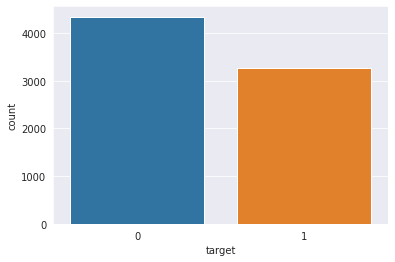

In [7]:
#distribution of target variable
sns.countplot(x='target', data=train)

## text

Now, let's take a look at some metadata that describe the text variable. Just out of curiousity, let's see if the length of the text (number of characters and the number of words) display a relationship with our target variable.

### Number of Characters

In [8]:
#find the distribution for the number of characters (for both target categories)
character_no_0 = train[train['target']==0]['text'].str.len()
character_no_1 = train[train['target']==1]['text'].str.len()

Text(0.5, 0.98, 'The distribution of number of characters in text')

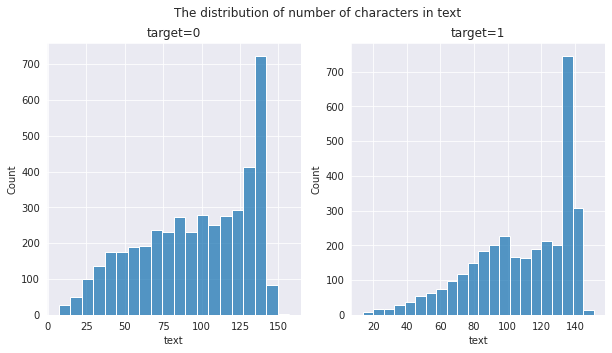

In [9]:
#create subplots
fig, ax = plt.subplots(1,2,figsize=(10,5))

#plot histogram
sns.histplot(ax = ax[0], x=character_no_0)
sns.histplot(ax = ax[1], x=character_no_1)

#set subplot titles
ax[0].set_title("target=0")
ax[1].set_title("target=1")

#set super title
fig.suptitle("The distribution of number of characters in text")

The distribution of the length of the text on a character level is roughly the same for both classes. This means that, regardless of whether a tweet is about a disaster or not, the length of tweets remain roughly the same. This shouldn't come as too surprising considering everyone writes tweets in a different way.

### Number of Words

In [10]:
#find the distribution for the number of words (for both target categories)
word_no_0 = train[train['target']==0]['text'].str.split().map(len)
word_no_1 = train[train['target']==1]['text'].str.split().map(len)

Text(0.5, 0.98, 'The distribution of number of words in text')

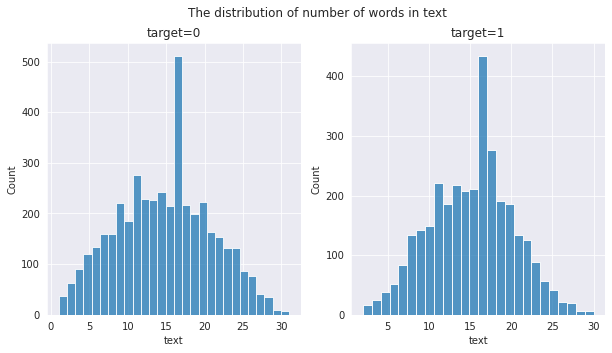

In [11]:
#create subplots
fig, ax = plt.subplots(1,2,figsize=(10,5))

#plot histogram
sns.histplot(ax = ax[0], x=word_no_0)
sns.histplot(ax = ax[1], x=word_no_1)

#set subplot titles
ax[0].set_title("target=0")
ax[1].set_title("target=1")

#set super title
fig.suptitle("The distribution of number of words in text")

The same can be said about the distribution for the number of words in text. There's just no significant difference in length of tweets between the two classes. 

## Keywords

Okay, let's take a look at the *keyword* variable then. Although we won't be using this variable in our classification, it's still worth for us to visualize it to see if we can extract some insights. Let's plot out the counts of keywords in each class and sort them from most the least.

In [12]:
#find the count of each keyword (for both target categories)
class0_keywords = train[train['target']==0]['keyword'].value_counts()
class1_keywords = train[train['target']==1]['keyword'].value_counts()

Text(0.5, 0.98, 'Count of Keywords')

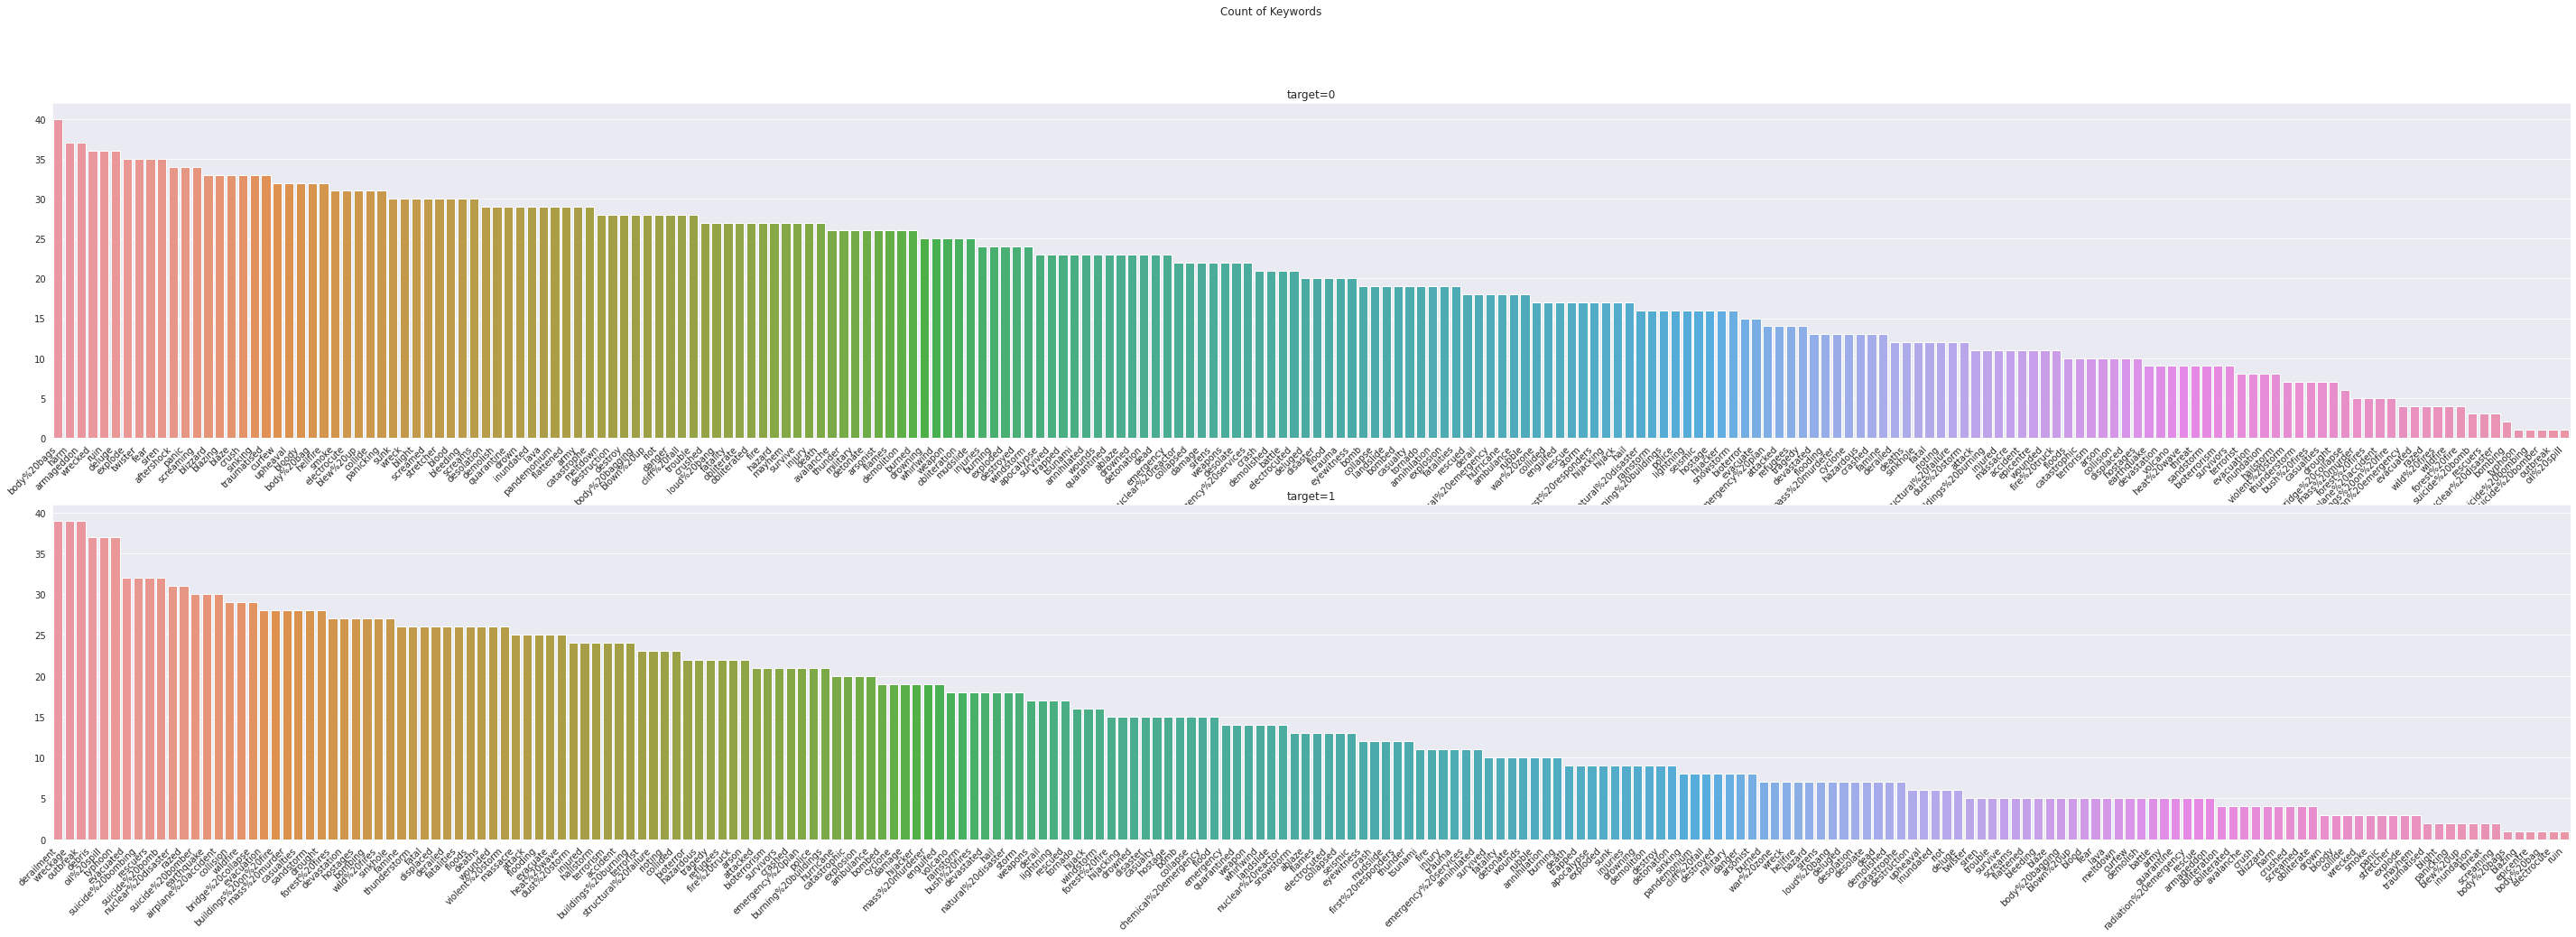

In [13]:
fig, ax = plt.subplots(2,1,figsize=(50, 15))

chart1=sns.barplot(ax=ax[0], x=class0_keywords.index, y=class0_keywords.values)
chart2=sns.barplot(ax=ax[1], x=class1_keywords.index, y=class1_keywords.values)

chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right');
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right');

ax[0].set_title("target=0")
ax[1].set_title("target=1")

fig.suptitle("Count of Keywords")

Wow! That's a lot keywords. We can see that keywords like derailment, wreckage, outbreak, debris ranked the top counts in disaster tweets, while body%20bags (what?), harm, armageddon and wrecked ranked the top counts in non-disaster tweets. We can certainly extract information by placing these two countplots side-by-side, but it's making my eyes hurt a little. Let's create a word cloud for each class instead.

In [14]:
#remove STOPWORDS from word cloud
stopwords = set(STOPWORDS)

### Class 0 Keywords

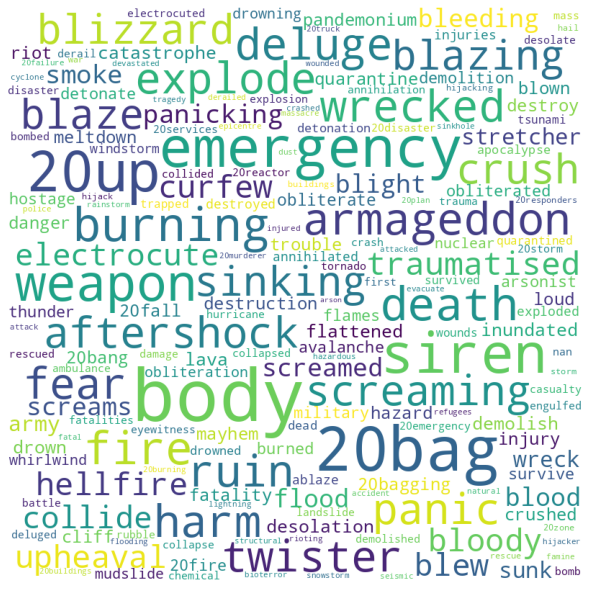

In [15]:
#create keyword string
keyword_str = ''

for keyword in train[train['target']==0]['keyword']:
    
    #skip missing keywords
    if keyword == "NaN":
        continue
        
    keyword=str(keyword)
    keyword_str += keyword + " "

#create word cloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10, max_font_size = 100, collocations=False, prefer_horizontal=1).generate(keyword_str)
 
# plot word cloud                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

We can see that even in class 0 (non-disaster tweets), we can observe many negative and frightening keywords. For instance, "death", "bloody", "blizzard", "fire" and "explode" are among the most commonly occured. These tweets were probably chosen specifically for this task so that the model is truly able to differentiate actual disaster tweets from tweets that are seemingly about disasters.

### Class 1 Keywords

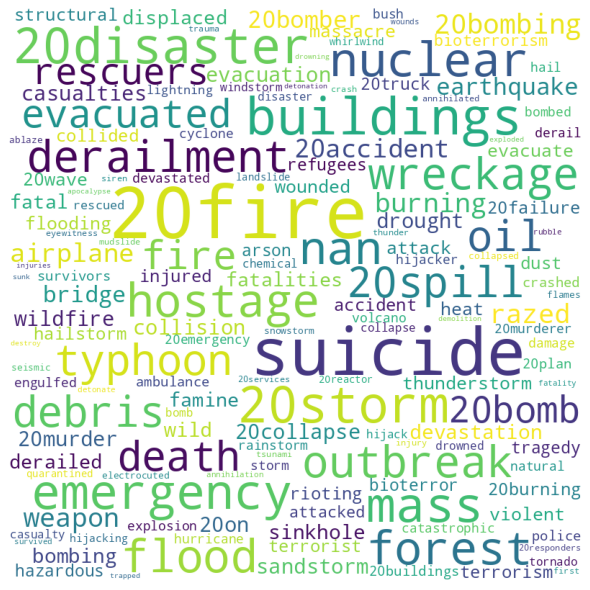

In [16]:
keyword_str = ''

for keyword in train[train['target']==1]['keyword']:
    
    if keyword == "NaN":
        continue
        
    keyword=str(keyword)
    keyword_str += keyword + " "

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10, max_font_size = 100, collocations=False, prefer_horizontal=1).generate(keyword_str)
                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In class 1, we can verify that most of the keywords are very much related to disasters (eg. "typhoon", "flood", "outbreak", "fire"). We can also see keywords like "suicide", "hostage" and "bomb", implying that we are not limited to just natural disasters, but also man-made ones.

# Data Cleaning

Okay, that was a quick and easy visualization of our dataset. I don't want to focus too much on the visualiation part, because the most important part really lies in the cleaning, processing and modelling of the text variable. Cleaning text is tedious and time-consuming task. We have to transform informal language that can take on almost any format into a structured text format. Thankfully, Gunes Evitan and his amazing notebook [NLP with Disaster Tweets - EDA, Cleaning and BERT](http://https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert) presented one of the most comprehensive cleaning I've ever seen. It is so well done that it would be a shame if I didn't adopt his work, so please go upvote his notebook because deserves every single one of them.  

Let's take a look at each step of the cleaning process.

* remove html
* remove emoji
* remove special character
* expand contraction
* expand slangs and abbreviations
* spelling correction
* remove url
* seperate punctuations
* expand acronyms

The functions that perform each of these steps are defined below. (Thanks again to Gunes Evitan!!!)

## Remove HTML

In [17]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

## Remove Emoji

In [18]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

## Remove Special Characters

In [19]:
def remove_special_character(tweet): 
            
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    return tweet

## Expand Contractions

In [20]:
def expand_contraction(tweet):
    
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)
    
    return tweet

## Entity References

In [21]:
def entity_references(tweet):
            
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    return tweet

## Slang and Typo Correction

In [22]:
def typos_slang_abbreviation(tweet):
    
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    return tweet

## #Hashtag Expansion

In [23]:
def hashtag_username(tweet):
    
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
    
    return tweet

## Remove URL

In [24]:
def remove_url(tweet):
    
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    
    return tweet

## Format Punctuations

In [25]:
def punctuation(tweet):
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    return tweet

## Expand Acronyms

In [26]:
def acronyms(tweet):
    
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

## Cleaning Function

Now, we can combine all of these functions into one and don't ever tell me this isn't beautiful work!

In [27]:
#combine all cleaning functions
def clean_text(text_list):
    
    cleaned_text_list = []
    for text in text_list:
        
        cleaned_text = remove_html(text)
        cleaned_text = remove_emoji(cleaned_text)
        cleaned_text = remove_special_character(cleaned_text)
        cleaned_text = expand_contraction(cleaned_text)
        cleaned_text = entity_references(cleaned_text)
        cleaned_text = typos_slang_abbreviation(cleaned_text)
        cleaned_text = hashtag_username(cleaned_text)
        cleaned_text = remove_url(cleaned_text)
        cleaned_text = punctuation(cleaned_text)
        cleaned_text = acronyms(cleaned_text)
        
        cleaned_text_list.append(cleaned_text)
    
    return cleaned_text_list

Let's call the function and iron out the wrinkles in the text.

In [28]:
train['cleaned_text'] = clean_text(train['text'])

train.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...


Awesome! The difference between the original text and the cleaned text should be quite apparent. Let's also clean the testing data by applying the same function.

In [29]:
#do the same for the testing dataset
test['cleaned_text'] = clean_text(test['text'])

Since processing these texts can take some time, let's output the dataframe so we don't have to clean it every time we run this code again. :D You should be able to download the dataset from the input column under the name *nlp-with-disaster-tweets-cleaned-data*.

In [30]:
#save cleaned_text for later use
train.to_csv("cleaned_train_data.csv", index=False)
test.to_csv("cleaned_test_data.csv", index=False)

# BERT

Awesome! We just completed the most tedious step of our project. Now, all we have to do is 1) tokenize our texts, 2) feed them into our model, and 3) classify. Since we're using transfer learning with BERT, we don't have to define our own neural network architecture. We kind of have to define the last classifer layer, but most things that we need are already organized in tensorflow. 

Okay, in case you've already cleaned the data and understood all that we've done until this step, you can access the cleaned data from either your output (from the previous cell) or the data input.

In [31]:
#read cleaned text data
train = pd.read_csv("/kaggle/input/nlp-with-disaster-tweets-cleaned-data/cleaned_train_data.csv")
test = pd.read_csv("/kaggle/input/nlp-with-disaster-tweets-cleaned-data/cleaned_test_data.csv")

There are two objects to setup for our BERT model, a tokenizer and the model architecture itself. The tokenizer is responsible for transforming the text data into tokens (or vectors that can be fed into the model). 

In [32]:
#text tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

#bert model
bert = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


We start by tokenizing our text data. There are several arguments we have to be wary of when applying this tokenizer

- `padding`: set the padding length of each tweet to `longest`, so that all tweets are fully tokenized
- `return_tensors`: set the the return_tensors to `tf` so that the tokenized text are compatible with tensorflow (set as `pt` if you're using PyTorch)
- `return_token_type_ids`: set this as `False` because we won't need it
- `return_attention_mask`: set this as `True` because we will need it

The tokenizer will return a dictionary with three keys: ***input_ids***, ***token_type_ids*** and ***attention_mask***. In case you were wondering what each of these keys resemble, here's a quick explanation.

* ***input_ids*** are quite easy to understand. These are the ids that map the tokens (words) to their respective ID, which should correspond to a pretrained embedding. Note that the tokenizer will add two special tokens into each sentence, one at the beginning and other at the end, to indicate when a sentence starts and ends.
* ***token_type_ids*** is a list of integers indciating which segment each token belongs to (0 for the first sequence, 1 for the second sequence). This list is primarily used in a next-sentence prediction or question-answering task, where two sentences are given. Since that's not our task here, we won't need this key.
* ***attention_mask*** is a list of 0s and 1s indicating which tokens should be attended by the model (1 for input tokens, 0 for padding tokens)


In [33]:
#tokenize our training dataset
x_train = tokenizer(text=train.cleaned_text.tolist(),          
                    padding='longest',                 #set padding to the longest text so we ensure all text are tokenized properly
                    return_tensors='tf',               #for tensorflow
                    return_token_type_ids = False,     #we don't need the token_type_ids in this case 
                    return_attention_mask = True,      #but we do need the attention mask
                    verbose = True)

print(x_train['input_ids'].shape, x_train['attention_mask'].shape)

(7613, 84) (7613, 84)


Let's print out and visualize the `input_ids` and `attention_mask` for a better understanding.

In [34]:
#input_ids
input_ids = x_train['input_ids']

#attention_mask
input_mask = x_train['attention_mask']

We can see here the input_ids for the first three tweets. All of them start with `101` and ends with `102`, the two added special tokens. Then each token in between represents each word within that tweet. The ending zeros are padding.

In [35]:
#the first three input_ids
print(input_ids[0:3])

tf.Tensor(
[[  101  2256 15616  2024  1996  3114  1997  2023  1001  8372  2089 16455
   9641  2149  2035   102     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [  101  3224  2543  2379  2474  6902  3351 21871  2243  1012  2710   102
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0 

The `attention_mask` is just a a list of 1s and 0s, indicating whether the token is a padding or not.

In [36]:
#the first three attention_mask
print(input_mask[0:3])

tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]], shape=(3, 84), dtype=int32)


It becomes more clear once we compare each of these tokens to the actual tweets. We can see that the word 'are' appears as the third word in the first tweet and the second last word in the third tweet. So if we refer to their position in the `input_id`, we can see that both ids are 2024 (because they're the same word!). 

In [37]:
#first three lines of cleaned text
print(train['cleaned_text'][0])
print(train['cleaned_text'][1])
print(train['cleaned_text'][2])

Our Deeds are the Reason of this  # earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask .  Canada
All residents asked to  ' shelter in place '  are being notified by officers .  No other evacuation or shelter in place orders are expected


The `input_ids` and `attention_mask` will be our two input X variables. And now that all of the texts are tokenized, let's extract the y variables from our training dataset as well.

In [38]:
#take out the target variable
y_train = train.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

## Training

Typically, in transfer learning, we freeze the pre-trained model weights and then add more layers on top of it so that the model can be adapted to another task. In this task, however, we will set the parameters within the bert model to also be trainable for better accuracy. In other words, we're basically adopting the BERT architecture and training it such that the model can be adapted to our task at hand. We'll also add some dropout and linear layers at the end of the BERT architecture for some final modification. Let's take a look.

In [39]:
#define the input_ids and attention_mask as input layers
input_ids = Input(shape=(84,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(84,), dtype=tf.int32, name="attention_mask")

#feed the input layers into the bert model
embeddings = bert(input_ids, attention_mask=input_mask)[1] #0 is the last hidden states,1 means pooler_output

#dropout layer to prevent overfitting
out = tf.keras.layers.Dropout(0.1)(embeddings)

#extra hidden layer to learn 
out = Dense(128, activation='relu')(out)

#dropout layer to prevent overfitting
out = tf.keras.layers.Dropout(0.1)(out)

#output layer
y = Dense(1,activation = 'sigmoid')(out)

#define input and output layer for model
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

#unfreeze the bert model parameters so the model can adapt to this current task
model.layers[2].trainable = True

#model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 84)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 84)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 1024)         0           tf_bert_model[0][1]          

In case you're having trouble understanding the architecture here, let's make some more clarifications.

1. We start by defining out input layer. As mentioned before, we have two inputs: the `input_ids` and the `attention_mask` derived from the tokenizer.
2. These two input layers will be fed into the BERT architecture. And we can decide whether we want the output of this BERT layer to be the `last_hidden_state` (index 0) or the `pooler_output` (index 1). Now you might be wondering, what's the difference the two? Here's a quick explanation.

The **last hidden state** and the **pooler output** are two different representations of the input sequence computed by the BERT model. The last hidden state is the final output of the model's transformer encoder. It is a sequence of vectors that represent the encoded input sequence, where each vector corresponds to a token in the input sequence and capture sinformation about the token's context and meaning based on its interactions with the other tokens in the sequence. The pooler output, on the other hand, is a single vector that summarizes the entire input sequence. It captures the overall semantics of the input sequence and is intended to be used as a high-level representation of the sequence.

The last hidden state and the pooler output may be suited for different tasks. If we're working on task that requires a sequence-level representation such as sequence labeling or text generation, the last hidden state would be more useful. For other tasks that require more of a high-level representation such as sentence classification or sentence similarity, the pooler output would be more useful. We could even use both of them to create a hybrid representation in very special cases. 

Okay, that was a very brief explanation of the last hidden state and the pooler output. If you don't have a strong background in **transformers** and **seq2seq models**, you might struggle to understand this. So I recommend you to study those first if you want to truly understand it. For now, just know that we're more inclined to use the pooler output since our task at hand is text classification.

3. We feed the pooler output to a dropout layer for some regularization. BERT is a powerful and sophisticated model, so regularization is very important.
4. Then we add a linear layer (relu as activation function).
5. Another dropout layer.
6. And finally our output layer with a sigmoid activation function for binary classification).

You'll also notice that we unfroze the third layer (index 3) of our model, which is our BERT layer. Again, we want the parameters in this BERT layer to be trainable such that these layers are adapted to fit our specific task. Although this will increase the training time and computational power, we would also achieve higher accuracy.

Okay, now let's compile our model and train! Let's not train for too long considering that the sophisticatedness of the BERT model could easily lead to overfitting. If you're training this on your own, you might achieve different results from mine, but the performance shouldn't vary by too much.

In [40]:
#compile the model
model.compile(optimizer = Adam(learning_rate=3e-05),
              loss = BinaryCrossentropy(), 
              metrics = BinaryAccuracy('accuracy'))

#train the model
final = model.fit(x ={'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
                  y = y_train,
                  validation_split = 0.2,
                  epochs=2,
                  batch_size=32,
                  shuffle=True)

Epoch 1/2
191/191 [==============================] - 241s 1s/step - loss: 0.4998 - accuracy: 0.7696 - val_loss: 0.3921 - val_accuracy: 0.8450
Epoch 2/2
191/191 [==============================] - 206s 1s/step - loss: 0.3614 - accuracy: 0.8598 - val_loss: 0.3652 - val_accuracy: 0.8431


Woohoo! In case you're happy with your results, you can save the model weights for later use with the code below.

In [41]:
#model.save_weights("bert_based.h5")

# DistilBERT

Awesome! We just trained a model using the BERT based model. According to our results, the validation accuracy is around 0.82-0.84, which is pretty good! (If you've seen the leaderboard, you'd know that the performance cap is right around 0.84). But let's see if we can do anything to improve our model, especially in terms of its computational speed and power. Here, I introduce **DistilBERT**, a smaller, lighter and faster version of the BERT based model. From `TFDistilBertForSequenceClassification`, we can download a a DistilBERT model that was trained specifically on a text classification task. This should make our lives much easier!

Just like before, let's download the tokenizer and model for DistilBERT. Notice that when we're setting up the `distilBERT` model, we also defined `num_labels` which is the number of class for our classification task. This is super convenient. 

In [42]:
#distilBERT tokenizer
distilTokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

#distilBERT model
distilBert = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_94', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

We tokenize our training text using our new `distilTokenizer`.

In [43]:
#tokenize our training dataset
x_train = distilTokenizer(text=train.cleaned_text.tolist(),          
                          padding='longest',                 #set padding to the longest text so we ensure all text are tokenized properly
                          return_tensors='tf',               #for tensorflow
                          return_token_type_ids = False,     #we don't need the token_type_ids in this case 
                          return_attention_mask = True,      #but we do need the attention mask
                          verbose = True)

print(x_train['input_ids'].shape, x_train['attention_mask'].shape)

(7613, 84) (7613, 84)


And then we define our new neural network architecture. You'll notice that I've opted for a much simpler model here. Since the DistilBERT we're using here was already pretrained on a text classification task, I didn't find the need to add additional layers at the end. (You can of course if you feel like it and feel free to try it out!) And since we've also already defined the `num_labels` when we're downloading the DistilBERT model, the model would output the exact shape that we need. There is no pooler output for DistilBERT.

In [44]:
#define the input layers
distil_input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
distil_attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')

#define the model inputs
inputs = {'input_ids': distil_input_ids, 'attention_mask': distil_attention_mask}

#define the model outputs
outputs = distilBert(inputs)
logits = outputs.logits

#define the model
distil_model = tf.keras.Model(inputs=inputs, outputs=logits)

#model summary
distil_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
tf_distil_bert_for_sequence_cla TFSequenceClassifier 66954241    attention_mask[0][0]             
                                                                 input_ids[0][0]                  
Total params: 66,954,241
Trainable params: 66,954,241
Non-trainable params: 0
__________________________________________________________________________________________________


Finally, let's compile and fit with the same hyperparameters as before. You should notice that the training speed is much faster than the BERT based model, while maintaining a similar accuracy and loss. This is good!

In [45]:
#compile the model
distil_model.compile(optimizer = Adam(learning_rate=3e-5),
                     loss = BinaryCrossentropy(from_logits=True), 
                     metrics = BinaryAccuracy('accuracy'))

#train the model
distil_final = distil_model.fit(
    x ={'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_split = 0.2,
    epochs=10,
    batch_size=32,
    shuffle=True)

Epoch 1/10
191/191 [==============================] - 45s 199ms/step - loss: 0.4513 - accuracy: 0.7924 - val_loss: 0.4013 - val_accuracy: 0.8339
Epoch 2/10
191/191 [==============================] - 36s 188ms/step - loss: 0.3345 - accuracy: 0.8662 - val_loss: 0.3792 - val_accuracy: 0.8404
Epoch 3/10
191/191 [==============================] - 36s 188ms/step - loss: 0.2456 - accuracy: 0.9115 - val_loss: 0.4594 - val_accuracy: 0.8286
Epoch 4/10
191/191 [==============================] - 36s 188ms/step - loss: 0.1729 - accuracy: 0.9396 - val_loss: 0.4738 - val_accuracy: 0.8267
Epoch 5/10
191/191 [==============================] - 36s 188ms/step - loss: 0.1240 - accuracy: 0.9560 - val_loss: 0.5998 - val_accuracy: 0.8155
Epoch 6/10
191/191 [==============================] - 36s 188ms/step - loss: 0.0952 - accuracy: 0.9634 - val_loss: 0.6771 - val_accuracy: 0.8207
Epoch 7/10
191/191 [==============================] - 36s 188ms/step - loss: 0.0775 - accuracy: 0.9686 - val_loss: 0.7386 - val_ac

Again, if you feel satisified with your model, you can save the weights using the code below for later use.

In [46]:
#distil_model.save_weights("distil_model.h5")

# Prediction

Woohoo! Now, that our models are trained, let's classify our testing dataset. We'll start with the BERT based model. Please make sure that you tokenize the testing dataset with the right tokenizer. The settings for the tokenizer should also be the same with the tokenizer you used for the training dataset.

In [47]:
#also tokenizee the testing dataset
x_test = tokenizer(
    text=test.cleaned_text.tolist(),
    add_special_tokens=True,
    
    #set the padding length to the same as the training dataset
    max_length=84,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

Then, we feed the tokenized testing dataset into our model and make predictions.

In [48]:
#predict with BERT based model
bert_base_predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

We'll perform the same procedures for the DistilBERT model. Again, don't mix up the tokenizer!

In [49]:
#also tokenizee the testing dataset
x_test_distil = distilTokenizer(
    text=test.cleaned_text.tolist(),
    add_special_tokens=True,
    
    #set the padding length to the same as the training dataset
    max_length=84,
    truncation=True,
    padding='max_length',    
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

#make predictions using distilBERT
distil_bert_predicted = distil_model.predict({'input_ids':x_test_distil['input_ids'],'attention_mask':x_test_distil['attention_mask']})

Just be cautious that the output of `distil_bert_predicted` is still in logits form. So, we'll have to use the sigmoid function to transform it such that it fits within 0 and 1.

In [50]:
#apply sigmoid function to distilBERT predictions
distil_bert_predicted = tf.nn.sigmoid(distil_bert_predicted)

Finally, let's assign the classes using the 0.5 threshold. The text will be classified as either 1 (disaster) or 0 (non-disaster).

In [51]:
#assign class to predictions
bert_base_predicted_label = np.where(bert_base_predicted>0.5,1,0)
distil_bert_predicted_label = np.where(distil_bert_predicted>0.5,1,0)

# Submission

Hooray! We're done! Let's save our prediction results and submit them to the leaderboard.

In [52]:
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

#save submission file for BERT based predictions
submission['target'] = bert_base_predicted_label
submission.to_csv("bert_based.csv", index=False)

#save submission file for DistilBERT predictions
submission['target'] = distil_bert_predicted_label
submission.to_csv("distil_bert.csv", index=False)

The results should fall around 83-84% accuracy, which is pretty good as stated before. We can certainly experiment with other hyperparameters, but this current model should do the job. The DistilBERT model, especially, does it in fast, light and cheap fashion. 

# Conclusion

In this notebook, we went through how to perform text classification using transfer learning (BERT and DistilBERT) and tensorflow. Hoped you learned something from this notebook and please upvote if you enjoyed it! Cheers <3